# Repeat the steps 1-6 with Least Square GAN and compare it with GAN results

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

import os

##  Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [ ]:
# Define transformations
transform = Compose([
    ToTensor(),
    Normalize(mean=(0.5,),
     std=(0.5,))
])

In [ ]:
fmnist = FashionMNIST(root='./data',
              train=True,
              download=True,
              transform=transform)

In [ ]:
test_dataset = FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [ ]:
img, label = fmnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

Function to reverse Normalization

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


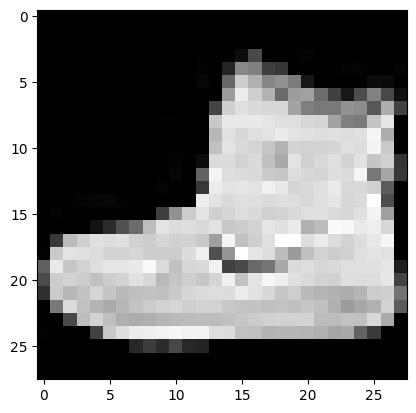

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

Loading the FMNIST dataset

In [ ]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fmnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([4, 1, 1, 7, 6, 7, 4, 2, 5, 3, 7, 9, 8, 3, 3, 6, 8, 6, 7, 1, 1, 5, 8, 7,
        5, 3, 8, 5, 6, 2, 1, 5, 1, 7, 5, 4, 8, 9, 3, 6, 9, 4, 1, 4, 9, 1, 1, 3,
        8, 1, 3, 7, 6, 3, 1, 9, 8, 3, 3, 2, 3, 6, 5, 3, 1, 7, 5, 0, 5, 1, 4, 6,
        3, 9, 5, 1, 8, 9, 4, 9, 1, 5, 9, 4, 4, 4, 7, 5, 4, 1, 5, 7, 6, 0, 4, 4,
        5, 6, 4, 9])


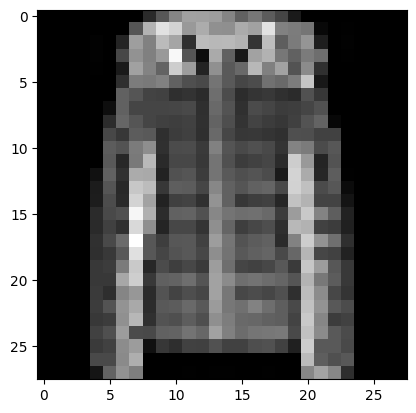

In [ ]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

## Discriminator Network

In [ ]:
image_size = 784
hidden_size = 256

In [ ]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [ ]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

Generator Network

In [ ]:
latent_size = 64

In [ ]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [ ]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

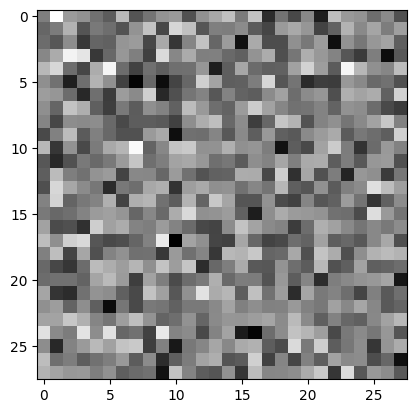

In [ ]:
plt.imshow(gen_imgs[0], cmap='gray');

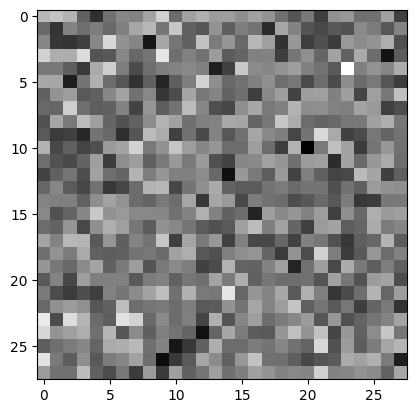

In [ ]:
plt.imshow(gen_imgs[1], cmap='gray');

In [ ]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

## Discriminator Training



Modifying the discriminator training for an LSGAN by:

Changing the loss function to MSE Loss (nn.MSELoss()) to stabilize training and produce higher-quality images.

In [ ]:
# changed loss to MSE loss for LSGAN
criterion = nn.MSELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

## Generator Training

In [ ]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

## Training the Model

In [ ]:
# Set the directory path relative to the current working directory
lsgan_sample_dir = 'Homework 5/LSGAN/samples'
if not os.path.exists(lsgan_sample_dir):
    os.makedirs(lsgan_sample_dir)

In [ ]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Homework 5',
 'mnist_gan.ipynb',
 'Part1.ipynb',
 'Part2.ipynb']

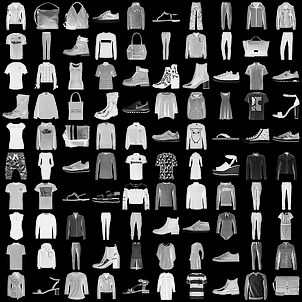

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(lsgan_sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(lsgan_sample_dir, 'real_images.png'))

Saving fake_images-0000.png


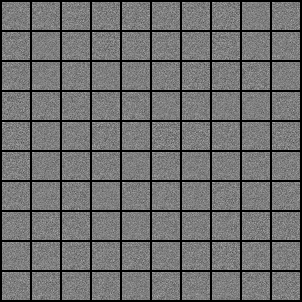

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(lsgan_sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(lsgan_sample_dir, 'fake_images-0000.png'))

## Step2. Train the GAN model to produce images in this new domain,

In [ ]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0113, g_loss: 0.9374, D(x): 0.96, D(G(z)): 0.07
Epoch [0/300], Step [400/600], d_loss: 0.0086, g_loss: 0.9757, D(x): 0.97, D(G(z)): 0.07
Epoch [0/300], Step [600/600], d_loss: 0.0251, g_loss: 0.9359, D(x): 0.94, D(G(z)): 0.08
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0020, g_loss: 0.9839, D(x): 0.99, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.0158, g_loss: 0.9330, D(x): 0.96, D(G(z)): 0.03
Epoch [1/300], Step [600/600], d_loss: 0.0030, g_loss: 0.9586, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0298, g_loss: 0.8911, D(x): 0.99, D(G(z)): 0.13
Epoch [2/300], Step [400/600], d_loss: 0.0024, g_loss: 0.9818, D(x): 0.99, D(G(z)): 0.02
Epoch [2/300], Step [600/600], d_loss: 0.0011, g_loss: 0.9865, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0629, g_loss: 0.9820, D(x): 0.96, D(G(z)): 0.08
Epoch [3/300], Step [400/6

## Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

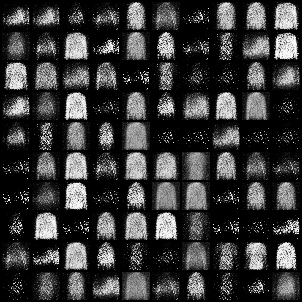

In [ ]:
Image('./Homework 5/LSGAN/samples/fake_images-0010.png')

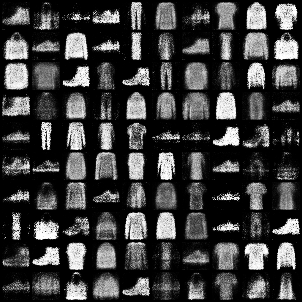

In [ ]:
Image('./Homework 5/LSGAN/samples/fake_images-0050.png')

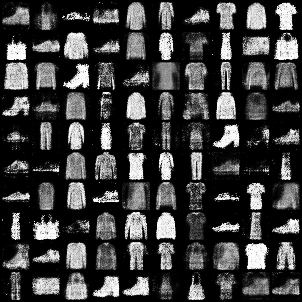

In [ ]:
Image('./Homework 5/LSGAN/samples/fake_images-0100.png')

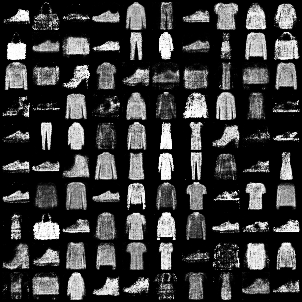

In [ ]:
Image('./Homework 5/LSGAN/samples/fake_images-0300.png')

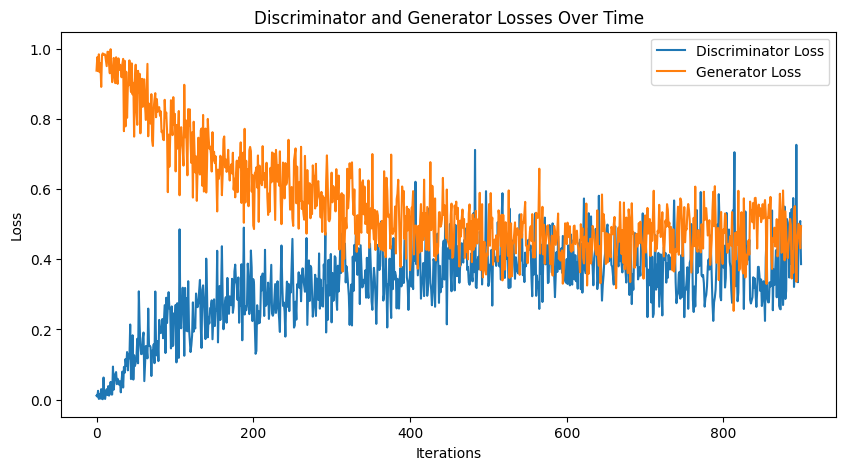

In [ ]:
# Plot discriminator loss
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Discriminator and Generator Losses Over Time')
plt.show()

 the graph indicates that the GAN is converging toward a balanced state where both the generator and discriminator are learning effectively, and neither is overpowering the other. This is generally a good sign in GAN training, suggesting that the generator is producing realistic images and the discriminator is challenging enough to keep improving both networks.

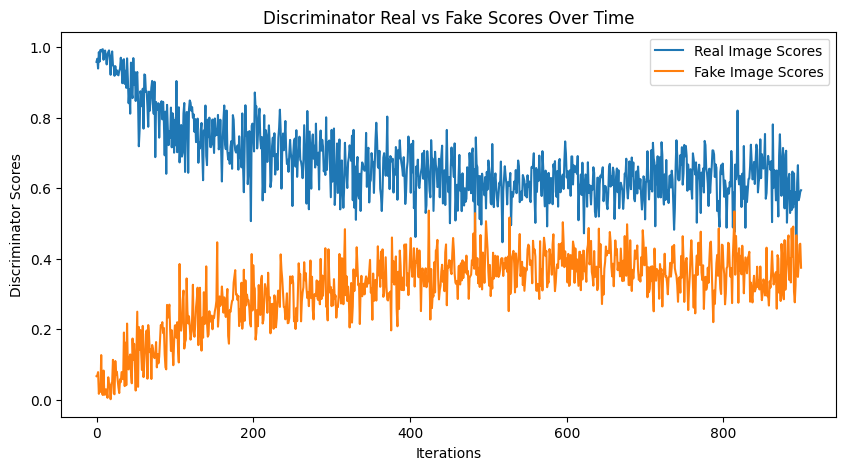

In [ ]:
# Plotting discriminator real vs fake score over time
plt.figure(figsize=(10, 5))
plt.plot(real_scores, label='Real Image Scores')
plt.plot(fake_scores, label='Fake Image Scores')
plt.xlabel('Iterations')
plt.ylabel('Discriminator Scores')
plt.legend()
plt.title('Discriminator Real vs Fake Scores Over Time')
plt.show()

* Convergence and Equilibrium: The convergence of the real and fake scores
suggests that the GAN is reaching a balanced state where the discriminator is not overly confident about real or fake images.
* Adversarial Balance: The narrowing gap between the scores implies that the discriminator is not significantly outperforming the generator; instead, both networks are learning effectively and challenging each other.
* Learning Dynamics: Initially, the discriminator has a strong ability to differentiate real and fake images, but as training progresses, the generator becomes better at producing realistic images, making it harder for the discriminator to distinguish between them.

# Step4. Save the model weights in the folder to be used later.

In [ ]:
# Define the paths to save the model weights
generator_path = os.path.join(lsgan_sample_dir, 'generator.pth')
discriminator_path = os.path.join(lsgan_sample_dir, 'discriminator.pth')

In [ ]:
# Save the generator model weights
torch.save(G.state_dict(), generator_path)
print(f"Generator weights saved at {generator_path}")

Generator weights saved at Homework 5/LSGAN/samples/generator.pth


In [ ]:
# Save the discriminator model weights
torch.save(D.state_dict(), discriminator_path)
print(f"Discriminator weights saved at {discriminator_path}")

Discriminator weights saved at Homework 5/LSGAN/samples/discriminator.pth


# Step5. Load the model using the saved weights.

In [ ]:
# Load the generator model weights
G.load_state_dict(torch.load(generator_path))
G.to(device)  # Move to the appropriate device
print(f"Generator weights loaded from {generator_path}")

Generator weights loaded from Homework 5/LSGAN/samples/generator.pth


In [ ]:
# Load the discriminator model weights
D.load_state_dict(torch.load(discriminator_path))
D.to(device)  # Move to the appropriate device
print(f"Discriminator weights loaded from {discriminator_path}")

Discriminator weights loaded from Homework 5/LSGAN/samples/discriminator.pth


# Step 6: Re-train the GAN model to see if you can improve.

In [ ]:
lsgan_base_dir = 'Homework 5/LSGAN'

In [ ]:
lsgan_base_dir

'Homework 5/LSGAN'

In [ ]:
# Define the new directory for saving re-trained images
retrained_image_dir = os.path.join(lsgan_base_dir, 'retrained_images')

# Create the directory if it doesn't exist
if not os.path.exists(retrained_image_dir):
    os.makedirs(retrained_image_dir)

In [ ]:
# Modify the save_fake_images function to save in the new folder
def save_retrained_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'retrained_fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(retrained_image_dir, fake_fname), nrow=10)

In [ ]:
# Re-train loop with saving images in the new folder
num_retrain_epochs = 200  # Number of additional epochs for re-training

for epoch in range(num_retrain_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load and reshape images to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Log losses every 200 steps
        if (i+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_retrain_epochs}], Step [{i+1}/{total_step}], '
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, '
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    # Save re-trained images in the retrained_images folder
    save_retrained_fake_images(epoch + 1 + num_epochs)

Epoch [1/200], Step [200/600], d_loss: 0.4010, g_loss: 0.4170, D(x): 0.62, D(G(z)): 0.37
Epoch [1/200], Step [400/600], d_loss: 0.3059, g_loss: 0.4558, D(x): 0.70, D(G(z)): 0.34
Epoch [1/200], Step [600/600], d_loss: 0.4038, g_loss: 0.5092, D(x): 0.60, D(G(z)): 0.37
Saving retrained_fake_images-0301.png
Epoch [2/200], Step [200/600], d_loss: 0.4504, g_loss: 0.4317, D(x): 0.58, D(G(z)): 0.41
Epoch [2/200], Step [400/600], d_loss: 0.4597, g_loss: 0.5389, D(x): 0.53, D(G(z)): 0.36
Epoch [2/200], Step [600/600], d_loss: 0.2861, g_loss: 0.4775, D(x): 0.65, D(G(z)): 0.31
Saving retrained_fake_images-0302.png
Epoch [3/200], Step [200/600], d_loss: 0.6464, g_loss: 0.3149, D(x): 0.55, D(G(z)): 0.56
Epoch [3/200], Step [400/600], d_loss: 0.2804, g_loss: 0.5464, D(x): 0.69, D(G(z)): 0.30
Epoch [3/200], Step [600/600], d_loss: 0.3758, g_loss: 0.4605, D(x): 0.59, D(G(z)): 0.33
Saving retrained_fake_images-0303.png
Epoch [4/200], Step [200/600], d_loss: 0.3542, g_loss: 0.3777, D(x): 0.63, D(G(z)): 0

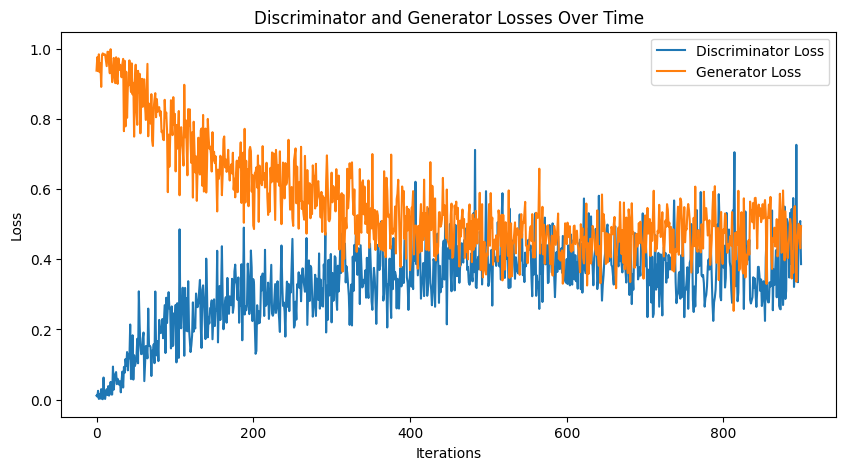

In [ ]:
# Plot discriminator loss
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Discriminator and Generator Losses Over Time')
plt.show()



*   Healthy GAN Training: The trend in the losses suggests a healthy training process, with the generator improving over time and reducing its loss, while the discriminator adjusts to maintain a moderate loss.
*   Reaching an Equilibrium: The final stage of training shows the losses fluctuating within a close range, indicating that the GAN has reached an equilibrium where the generator produces sufficiently realistic images, and the discriminator performs reasonably well in classification.
*   Loss Ranges: The fact that the losses hover between 0.3-0.6 suggests that neither the generator nor the discriminator is "winning" the adversarial game outright, which is generally desirable for achieving realistic image generation.



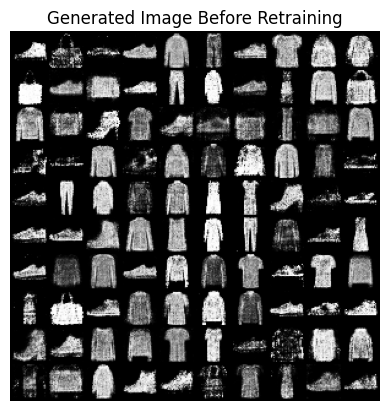

In [ ]:
# Load and display a generated image before retraining
before_img_path = os.path.join(lsgan_sample_dir, 'fake_images-0300.png')
before_img = plt.imread(before_img_path)
plt.imshow(before_img, cmap='gray')
plt.title('Generated Image Before Retraining')
plt.axis('off')
plt.show()

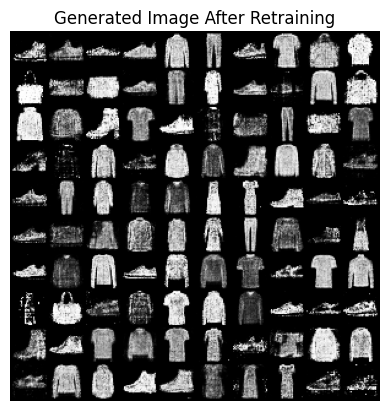

In [ ]:
# Load and display a generated image after retraining
after_img_path = os.path.join(retrained_image_dir, 'retrained_fake_images-0500.png')  # Adjust epoch index
after_img = plt.imread(after_img_path)
plt.imshow(after_img, cmap='gray')
plt.title('Generated Image After Retraining')
plt.axis('off')
plt.show()

## Step 7: Save the model weights without using checkpoints.

In [ ]:
# Define new paths to save the re-trained model weights
retrained_generator_path = os.path.join(retrained_image_dir, 'retrained_generator.pth')
retrained_discriminator_path = os.path.join(retrained_image_dir, 'retrained_discriminator.pth')

In [ ]:
# Save the re-trained generator model weights
torch.save(G.state_dict(), retrained_generator_path)
print(f"Re-trained generator weights saved at {retrained_generator_path}")

Re-trained generator weights saved at Homework 5/LSGAN/retrained_images/retrained_generator.pth


In [ ]:
# Save the re-trained discriminator model weights
torch.save(D.state_dict(), retrained_discriminator_path)
print(f"Re-trained discriminator weights saved at {retrained_discriminator_path}")

Re-trained discriminator weights saved at Homework 5/LSGAN/retrained_images/retrained_discriminator.pth


## Step 8: Load the model weights without using checkpoints.

In [ ]:
#Load the re-trained generator model weights
G.load_state_dict(torch.load(retrained_generator_path))
G.to(device)  # Move the model to the appropriate device
print(f"Re-trained generator weights loaded from {retrained_generator_path}")

Re-trained generator weights loaded from Homework 5/LSGAN/retrained_images/retrained_generator.pth


In [ ]:
#Load the re-trained discriminator model weights
D.load_state_dict(torch.load(retrained_discriminator_path))
D.to(device)  # Move the model to the appropriate device
print(f"Re-trained discriminator weights loaded from {retrained_discriminator_path}")

Re-trained discriminator weights loaded from Homework 5/LSGAN/retrained_images/retrained_discriminator.pth
